In [1]:
%load_ext autoreload
%autoreload 2

# Importance of OCT-derived Biomarkers for the Recurrence of Central Serous Chorioretinopathy using Statistics and Predictive Modelling

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.append("T:/Studies/CSCR/code/cscr_stats_ml")
import pandas as pd
import matplotlib.pyplot as plt

data_path = "T:/Studies/CSCR/code/cscr_stats_ml/CSCR_data.json"

constant_dict = {
    "INPUT_STATIC_FEATURES" : ["ID", "laterality", "sex", "label"],
    "INPUT_TIME_SERIES_FEATURES" : ["date", "SRF", "IRF", "PED", "RNFL", "GCL+IPL", "INL+OPL", "ONL", "PR+RPE", "CC+CS", "CVI", "DSCORE", "PV_AREA", "age"],
    "BIOMARKER_NAMES" : ["SRF", "IRF", "PED", "RNFL", "GCL+IPL", "INL+OPL", "ONL", "PR+RPE", "CC+CS", "CVI", "DSCORE", "PV_AREA"],
    "BINARY_FEATURES_MAPPINGS" : {"sex":{"M":1,"F":0}},
    "AGE_FEATURE_NAME" : "age",
    "DISCRIMINATOR": "label"
}

constant_dict['BINARY_FEATURES'] = list(constant_dict['BINARY_FEATURES_MAPPINGS'].keys())
constant_dict['CONTINUOUS_FEATURES'] = constant_dict['BIOMARKER_NAMES'] + [constant_dict['AGE_FEATURE_NAME']]
constant_dict['FEATURE_NAMES'] =  constant_dict['BINARY_FEATURES']+constant_dict['CONTINUOUS_FEATURES']

# Correlation

In [3]:
from correlation import main as correlation

args = pd.Series({'dataset_path': data_path, 'discriminator_name': 'label', 
                  'alpha': 0.05, 'constant_dict': constant_dict, 'trunc': False, 
                  'config':'', 
                  'visit_level_log_features': {"SRF":1, "IRF":2, "PED": 1, "RNFL": 1, "DSCORE":1}})

# It is also possible to pass the arguments in a file like this:
# args = pd.Series({'config':'file_path\file_name.json'})

corr_matrix, mask = correlation(args)

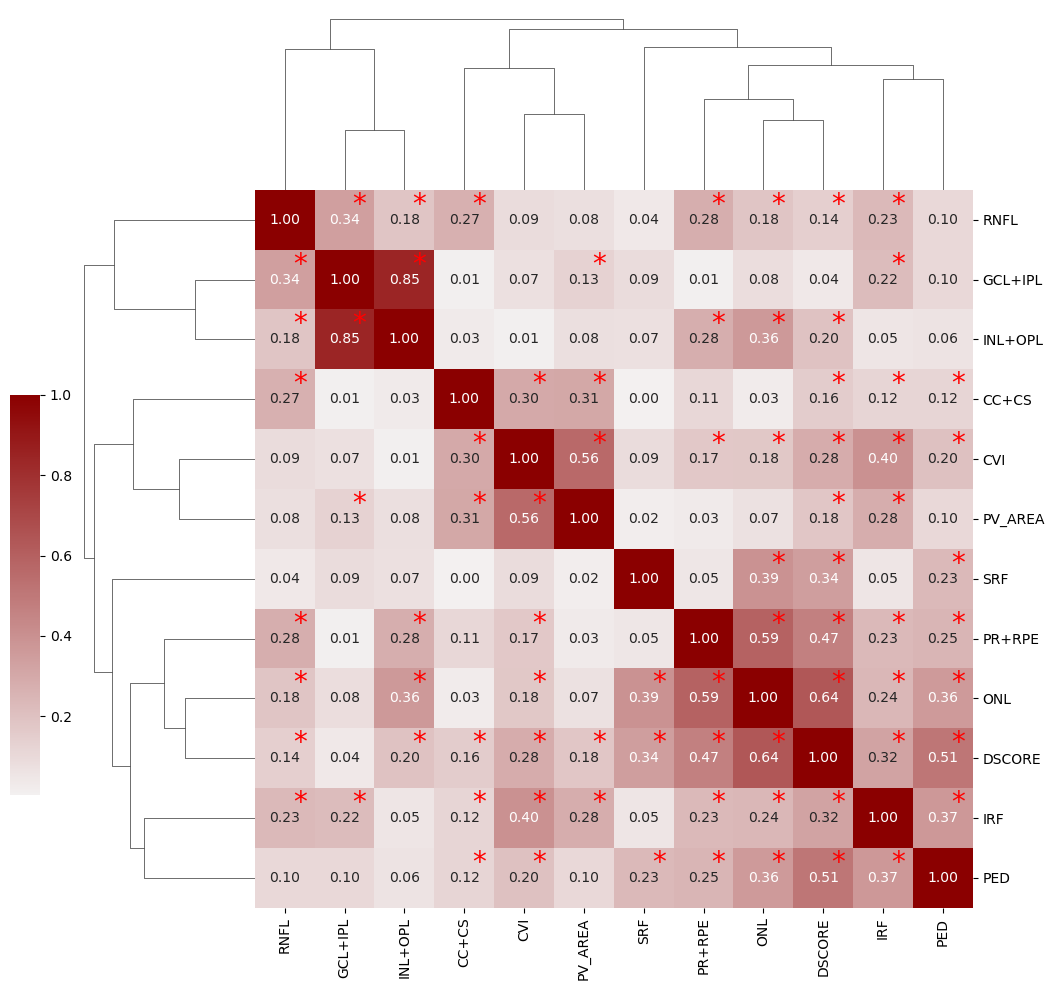

In [4]:
from seaborn import light_palette, clustermap

cmap = light_palette('darkred', n_colors=500)
g= clustermap(corr_matrix, cmap=cmap, fmt=".2f", cbar_pos=(-0.05, .2, .03, .4), annot=True)
biomarker_names = ["SRF", "IRF", "PED", "RNFL", "GCL+IPL", "INL+OPL", "ONL", "PR+RPE", "CC+CS", "CVI", "DSCORE", "PV_AREA"]

x_ticks_label = [x.get_text() for x in g.ax_heatmap.get_xticklabels()]
for i, bio1 in enumerate(biomarker_names):
    for j, bio2 in enumerate(biomarker_names):
        if mask.at[bio1, bio2]:
            i = x_ticks_label.index(bio1)
            j = x_ticks_label.index(bio2)
            g.ax_heatmap.text(i+0.75, j+0.25, "*", ha='center', va='center', fontsize=20, color='red')
plt.show()

# Statistical tests

In [5]:
from stat_test import main as stats_pipeline

### T-test with single visit

In [6]:
args = pd.Series({
    "dataset_path": data_path,
    "discriminator_name": "label", "alpha": 0.05, "stats_test": "ttest", "correction_method": 'fdr_bh',
    "features_order": ["age", "sex", "SRF", "PED", "IRF", "RNFL", "GCL+IPL", "INL+OPL", "ONL", "PR+RPE", "CC+CS", "CVI", "DSCORE", "PV_AREA"],
    "constant_dict": constant_dict, "per_patient": "first", "trunc": True, "config": ''
})

stats_results_df = stats_pipeline(args)

In [7]:
stats_results_df['P_Value']

sex        0.618062
SRF        0.593535
IRF        0.833088
PED        0.618062
RNFL       0.593535
GCL+IPL    0.618062
INL+OPL    0.396109
ONL        0.020040
PR+RPE     0.417069
CC+CS      0.593535
CVI        0.396109
DSCORE     0.002932
PV_AREA    0.593535
age        0.013641
Name: P_Value, dtype: float64

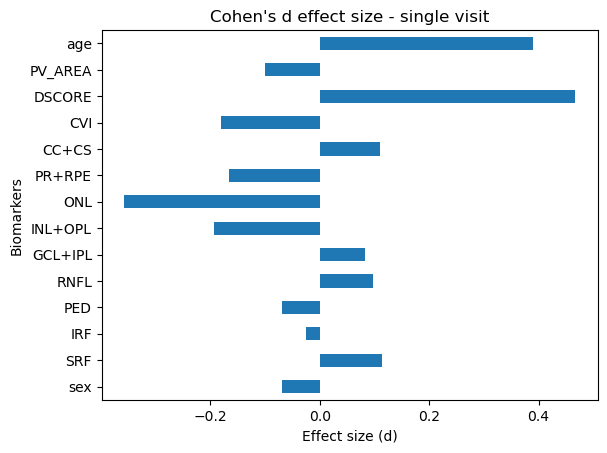

In [8]:
stats_results_df.plot.barh(y='Cohen_D', legend=None)
plt.title('Cohen\'s d effect size - single visit')
plt.xlabel('Effect size (d)')
plt.ylabel('Biomarkers')
plt.show()

### K-S test with longitudinal data

In [9]:
args = pd.Series({
    "dataset_path": data_path,
    "discriminator_name": "label", "alpha": 0.05, "stats_test": "ks",
    "correction_method": "fdr_bh",
    "features_order": ["age", "sex", "SRF", "PED", "IRF", "RNFL", "GCL+IPL", "INL+OPL", "ONL", "PR+RPE", "CC+CS", "CVI", "DSCORE", "PV_AREA"],
    "constant_dict": constant_dict,
    "per_patient": "mean",
    "trunc": True,
    "config": ''
})

stats_results_df = stats_pipeline(args)

In [10]:
stats_results_df['P_Value']

sex        1.000000
SRF        0.429877
IRF        0.078501
PED        0.021002
RNFL       0.921206
GCL+IPL    1.000000
INL+OPL    0.921206
ONL        0.030254
PR+RPE     0.429877
CC+CS      0.485378
CVI        0.078501
DSCORE     0.021002
PV_AREA    0.921206
age        0.040767
Name: P_Value, dtype: float64

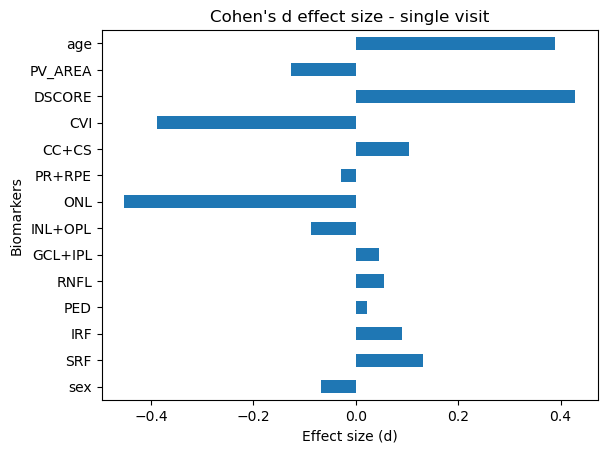

In [11]:
stats_results_df.plot.barh(y='Cohen_D', legend=None)
plt.title('Cohen\'s d effect size - single visit')
plt.xlabel('Effect size (d)')
plt.ylabel('Biomarkers')
plt.show()

# Predictive Modeling

In [12]:
from stat_model import logistic_regression

df_lr = logistic_regression(dataset_path=data_path, constant_dict=constant_dict, multi=False, trunc=True)

In [13]:
df_lr['P-value']

sex        8.657949e-01
SRF        9.943589e-11
IRF        3.372475e-06
PED        1.988157e-09
RNFL       4.727665e-01
GCL+IPL    6.256352e-01
INL+OPL    2.431538e-02
ONL        5.166629e-13
PR+RPE     2.647855e-01
CC+CS      1.867718e-02
CVI        2.734493e-05
DSCORE     1.071248e-11
PV_AREA    3.682425e-01
age        9.980430e-09
Name: P-value, dtype: float64

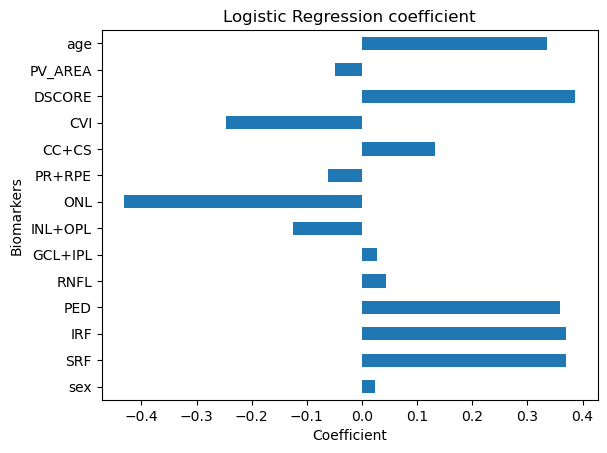

In [14]:
df_lr.plot.barh(y='Coefficient', legend=None)
plt.title('Logistic Regression coefficient')
plt.xlabel('Coefficient')
plt.ylabel('Biomarkers')
plt.show()